<a href="https://colab.research.google.com/github/Affanamin/pytorch-CNN/blob/main/pyntorch_CNN_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Data reading.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"affanamin","key":"d6275d94dccb8c6f91c2a21d77358561"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [ ]:
! kaggle datasets download -d puneet6060/intel-image-classification

 95% 329M/346M [00:11<00:00, 27.5MB/s]
100% 346M/346M [00:11<00:00, 30.8MB/s]


In [ ]:
!mkdir dataset

In [ ]:
!unzip -q intel-image-classification.zip -d dataset/  #unzip data in dataset/

In [ ]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

%matplotlib inline

In [ ]:
import os
#Give dataset path
data_dir1 = "dataset/seg_train"
data_dir2 = "dataset/seg_test"
train_dir = data_dir1 + "/seg_train"
valid_dir = data_dir2 + "/seg_test/"
outcomes = os.listdir(train_dir)

In [ ]:
# printing the all outcomes
print(outcomes)

['forest', 'buildings', 'mountain', 'glacier', 'street', 'sea']


In [ ]:
print("Total outcome classes are: {}".format(len(outcomes)))

Total outcome classes are: 6


In [ ]:
# Number of images for each Class
nums = {}
for outcome in outcomes:
    nums[outcome] = len(os.listdir(train_dir + '/' + outcome))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
forest,2271
buildings,2191
mountain,2512
glacier,2404
street,2382
sea,2274


Text(0.5, 1.0, 'Images per each class :')

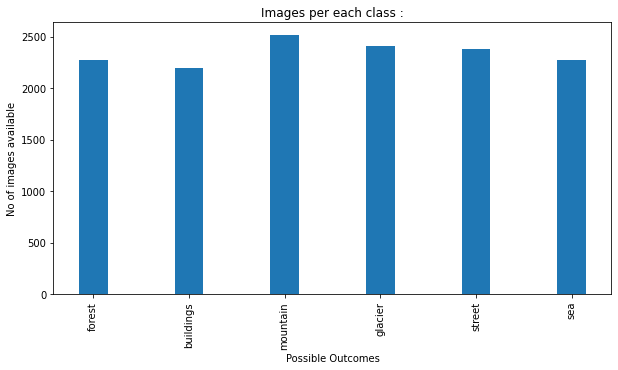

In [ ]:
# plotting number of images available for each disease
index = [n for n in range(6)]
plt.figure(figsize=(10, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Possible Outcomes', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, outcomes, fontsize=10, rotation=90)
plt.title('Images per each class :')

In [ ]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 14034 images for training


In [ ]:
from torchvision.transforms import ToTensor,Resize,Normalize

In [ ]:
# datasets for validation and training
#train = ImageFolder(train_dir, transform=transforms.ToTensor())
#valid = ImageFolder(valid_dir, transform=transforms.ToTensor()) 
#train = ImageFolder(train_dir, transform=transforms.Resize((224,224)))



In [ ]:
transforms = transforms.Compose([Resize((256,256)),
                         ToTensor(),
                         Normalize([0.485,0.456,0.406],[0.299,0.224,0.225])])

In [ ]:
train = ImageFolder(root=train_dir,transform=transforms)

In [ ]:
valid = ImageFolder(root=valid_dir,transform=transforms)

In [ ]:
img, label = train[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [ ]:
# total number of classes in train set
len(train.classes)

6

In [ ]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label :buildings(0)


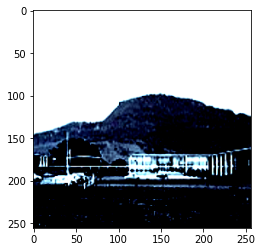

In [ ]:
show_image(*train[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label :mountain(3)


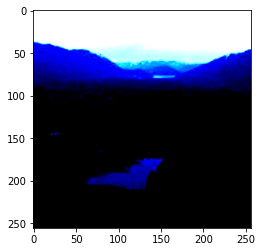

In [ ]:
show_image(*train[7000])

In [ ]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

In [ ]:
# setting the batch size
batch_size = 32

In [ ]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [ ]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


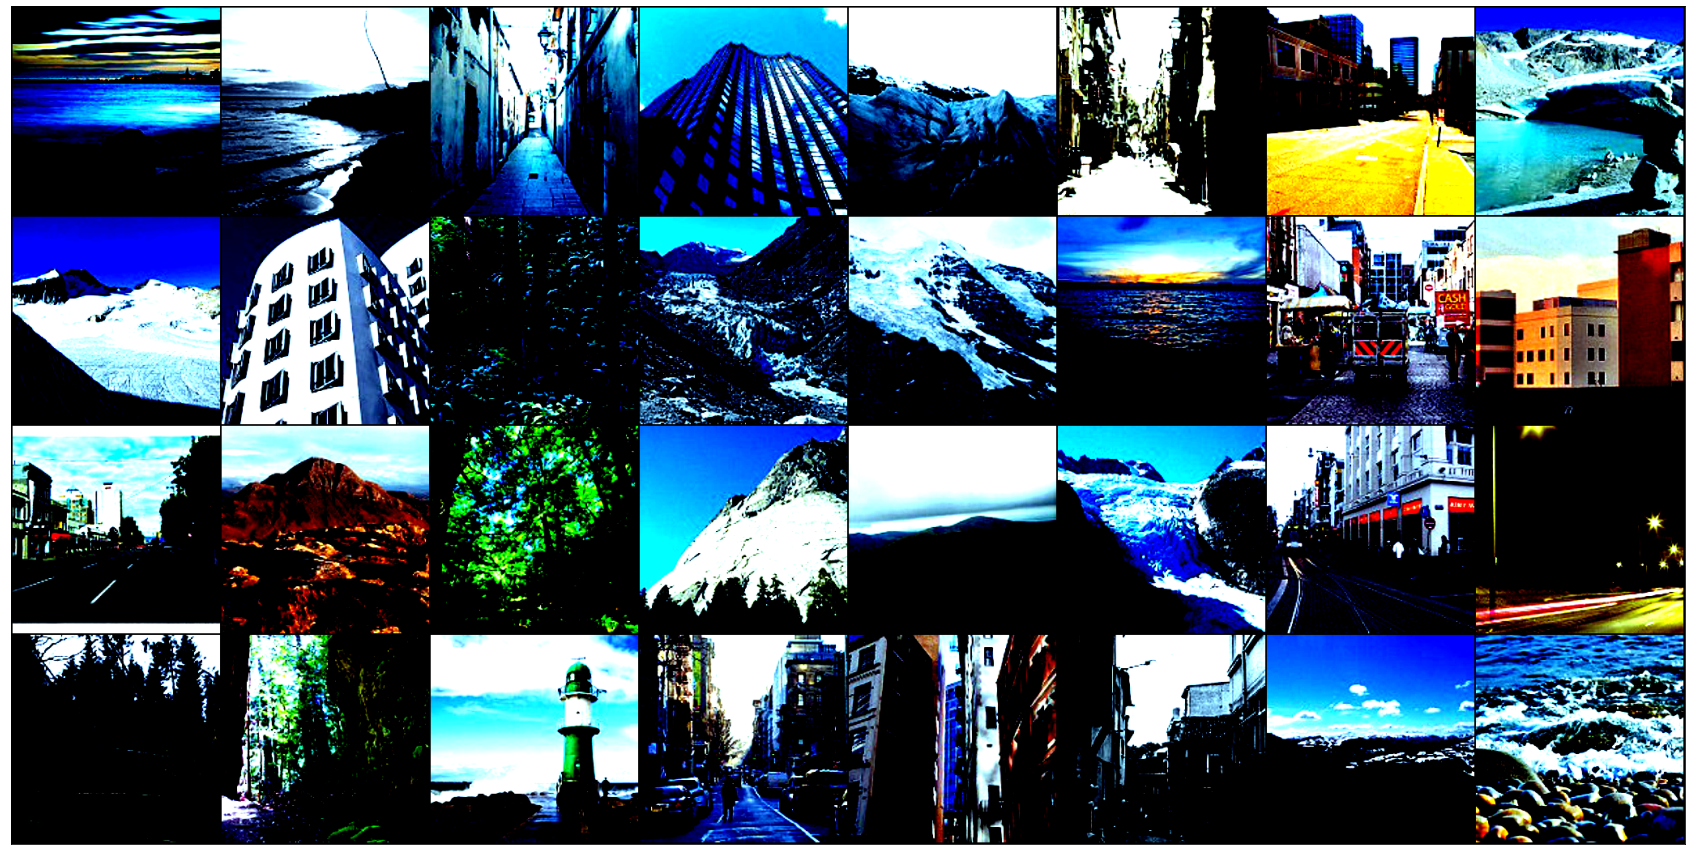

In [ ]:
# Images for first batch of training
show_batch(train_dl) 

In [ ]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
#<<< ------------------------------------------------------------------------------------------->>>

In [ ]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))
        

In [ ]:
len(train.classes)


6

In [ ]:
# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

In [ ]:
# defining the model and moving it to the GPU
model = to_device(ResNet9(3, len(train.classes)), device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [ ]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history
    

In [ ]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 14.4 s, sys: 12.2 s, total: 26.5 s
Wall time: 26.7 s


In [ ]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=1e-4, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00812, train_loss: 1.0514, val_loss: 0.8285, val_acc: 0.7189
Epoch [1], last_lr: 0.00000, train_loss: 0.4913, val_loss: 0.3545, val_acc: 0.8743
CPU times: user 7min 28s, sys: 7min 59s, total: 15min 27s
Wall time: 15min 22s


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

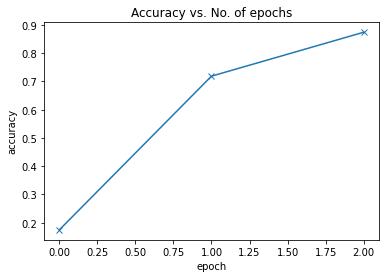

In [ ]:
plot_accuracies(history)

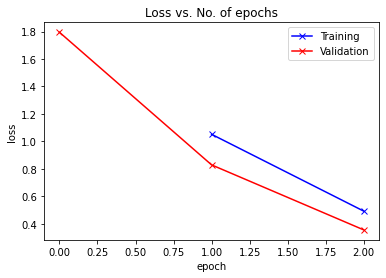

In [ ]:
plot_losses(history)

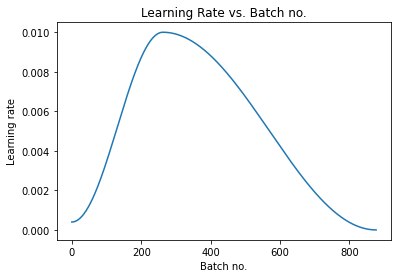

In [ ]:
plot_lrs(history)

In [ ]:
#data_dir3 = "dataset/seg_pred/seg_pred"
#test_dir = data_dir3 + "seg_pred"
#valid_dir = data_dir2 + "/seg_test/"
data_dir2 = "dataset/seg_test/seg_test"

valid_dir = data_dir2 

In [ ]:
valid_dir

'dataset/seg_test/seg_test'

In [ ]:
test = ImageFolder(root=valid_dir,transform=transforms)


In [ ]:
test

Dataset ImageFolder
    Number of datapoints: 3000
    Root location: dataset/seg_test/seg_test
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.299, 0.224, 0.225])
           )

In [ ]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 10004.jpg , Predicted: buildings


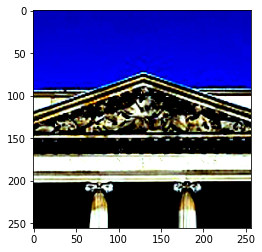

In [ ]:
# predicting first image
img, label = test[4]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))

In [ ]:
# getting all predictions (actual label vs predicted)
for i, (img, label) in enumerate(test):
    print('Label:', test_images[i], ', Predicted:', predict_image(img, model))

Label: 12045.jpg , Predicted: forest
Label: 12052.jpg , Predicted: forest
Label: 12056.jpg , Predicted: forest
Label: 12057.jpg , Predicted: forest
Label: 1206.jpg , Predicted: forest
Label: 12061.jpg , Predicted: forest
Label: 12062.jpg , Predicted: forest
Label: 1207.jpg , Predicted: forest
Label: 12072.jpg , Predicted: forest
Label: 12073.jpg , Predicted: forest
Label: 12076.jpg , Predicted: forest
Label: 12078.jpg , Predicted: forest
Label: 12079.jpg , Predicted: forest
Label: 12080.jpg , Predicted: forest
Label: 12082.jpg , Predicted: forest
Label: 12085.jpg , Predicted: forest
Label: 12086.jpg , Predicted: forest
Label: 12087.jpg , Predicted: forest
Label: 12088.jpg , Predicted: forest
Label: 12090.jpg , Predicted: forest
Label: 12095.jpg , Predicted: forest
Label: 12098.jpg , Predicted: forest
Label: 12099.jpg , Predicted: forest
Label: 121.jpg , Predicted: forest
Label: 12100.jpg , Predicted: forest
Label: 12109.jpg , Predicted: forest
Label: 1211.jpg , Predicted: forest
Label:

KeyboardInterrupt: ignored

In [ ]:
# saving the entire model to working directory
PATH = './ImageClassification_pytorch.pth'
torch.save(model, PATH)